In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
MEASUREMENTS_FILE = 'measurements_level3_v11.csv'
# Select a high Vds value where the MOSFET is likely in saturation
# Check the simulation parameters in your script (page 2 [cite: 4]) if unsure, default VDS_STOP was 5.0V
VDS_SATURATION = 5.0

# --- Load Data ---
try:
    df_meas = pd.read_csv(MEASUREMENTS_FILE)
    print(f"Successfully loaded {MEASUREMENTS_FILE}")
    print(f"Columns: {df_meas.columns.tolist()}")
    print(f"Unique MOSFET IDs found: {df_meas['MOSFET_ID'].unique()}")
except FileNotFoundError:
    print(f"Error: {MEASUREMENTS_FILE} not found. Please ensure it's in the same directory.")
    # Exit or handle error appropriately in a real script
    df_meas = pd.DataFrame() # Create empty DataFrame to avoid subsequent errors



Successfully loaded measurements_level3_v11.csv
Columns: ['MOSFET_ID', 'meas_index', 'VGS', 'VDS', 'ID']
Unique MOSFET IDs found: [    1     2     3 ... 54998 54999 55000]


In [23]:
# --- Select MOSFET ---
if not df_meas.empty:
    # Select the first MOSFET ID found in the file
    selected_mosfet_id = 17211 # Change this to the desired MOSFET ID if needed
    print(f"\nSelecting data for MOSFET_ID: {selected_mosfet_id}")
    df_single_mosfet = df_meas[df_meas['MOSFET_ID'] == selected_mosfet_id].copy()
    print(f"Data points for selected MOSFET: {len(df_single_mosfet)}")
    print("\nSample data for selected MOSFET:")
    print(df_single_mosfet.head())
else:
    print("Cannot proceed without measurement data.")


Selecting data for MOSFET_ID: 17211
Data points for selected MOSFET: 561

Sample data for selected MOSFET:
         MOSFET_ID  meas_index  VGS  VDS            ID
9654810      17211           0  0.0  0.0 -3.952417e-30
9654811      17211           1  0.0  0.1  4.860470e-13
9654812      17211           2  0.0  0.2  2.989028e-13
9654813      17211           3  0.0  0.3  3.991018e-13
9654814      17211           4  0.0  0.4  4.991502e-13


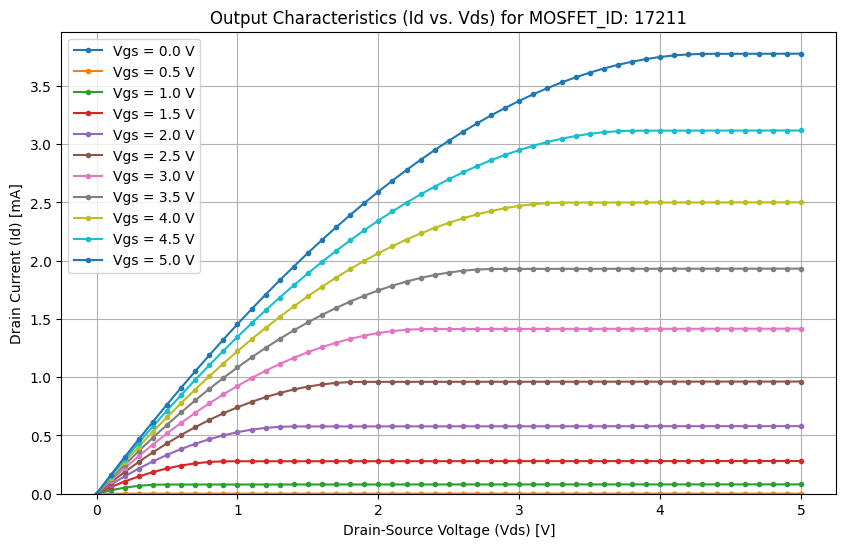

In [24]:
if not df_single_mosfet.empty:
    plt.figure(figsize=(10, 6))
    
    # Get unique Vgs values, sort them
    vgs_values = sorted(df_single_mosfet['VGS'].unique())
    
    for vgs in vgs_values:
        df_vgs = df_single_mosfet[df_single_mosfet['VGS'] == vgs]
        # Ensure data is sorted by Vds for plotting lines correctly
        df_vgs = df_vgs.sort_values('VDS')
        plt.plot(df_vgs['VDS'], df_vgs['ID'] * 1000, marker='.', linestyle='-', label=f'Vgs = {vgs:.1f} V') # Plot Id in mA

    plt.title(f'Output Characteristics (Id vs. Vds) for MOSFET_ID: {selected_mosfet_id}')
    plt.xlabel('Drain-Source Voltage (Vds) [V]')
    plt.ylabel('Drain Current (Id) [mA]')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0) # Start y-axis at 0
    plt.show()
else:
    print("Skipping output characteristics plot due to missing data.")

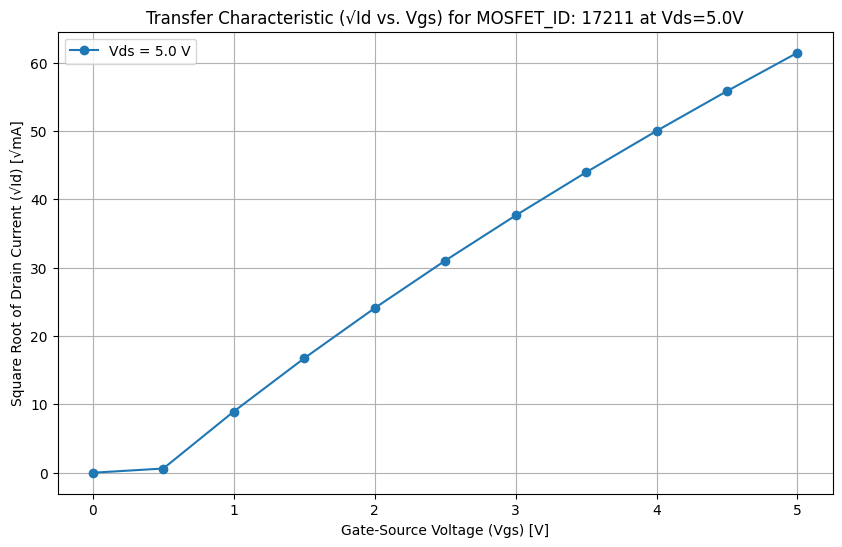


Data prepared for extrapolation (saturation region):
         VGS            ID   SQRT_ID
9654860  0.0  5.099185e-12  0.000002
9654911  0.5  3.802015e-07  0.000617
9654962  1.0  8.026265e-05  0.008959
9655013  1.5  2.805901e-04  0.016751
9655064  2.0  5.800368e-04  0.024084


In [25]:
if not df_single_mosfet.empty:
    # Filter data for the chosen Vds value
    df_sat = df_single_mosfet[np.isclose(df_single_mosfet['VDS'], VDS_SATURATION)].copy()
    
    if not df_sat.empty:
        # Calculate sqrt(Id), handle potential non-positive values if any
        # Add a small epsilon or filter out non-positive Id if necessary
        df_sat['SQRT_ID'] = np.sqrt(df_sat['ID'].clip(lower=0)) # Ensure Id is non-negative

        # Sort by Vgs for plotting
        df_sat = df_sat.sort_values('VGS')

        # --- Plot sqrt(Id) vs Vgs ---
        plt.figure(figsize=(10, 6))
        plt.plot(df_sat['VGS'], df_sat['SQRT_ID'] * 1000, marker='o', linestyle='-', label=f'Vds = {VDS_SATURATION} V') # Plot sqrt(Id) in (mA)^0.5

        plt.title(f'Transfer Characteristic (√Id vs. Vgs) for MOSFET_ID: {selected_mosfet_id} at Vds={VDS_SATURATION}V')
        plt.xlabel('Gate-Source Voltage (Vgs) [V]')
        plt.ylabel('Square Root of Drain Current (√Id) [√mA]')
        plt.grid(True)
        plt.legend()
        plt.show()

        print("\nData prepared for extrapolation (saturation region):")
        print(df_sat[['VGS', 'ID', 'SQRT_ID']].head())
    else:
        print(f"No data found for Vds = {VDS_SATURATION}V. Cannot plot √Id vs Vgs or perform extrapolation.")
        # Set df_sat to empty to prevent errors in next steps
        df_sat = pd.DataFrame()
else:
    print("Skipping saturation data selection due to missing initial data.")
    df_sat = pd.DataFrame()

In [26]:
# --- Threshold Voltage Extrapolation ---
if not df_sat.empty:
    # Define the range of Vgs for linear fitting
    # Heuristic: Use points where Vgs is clearly above the 'knee' of the curve.
    # This might need adjustment based on the plot from Part 3.
    # Let's try Vgs > 1.5V as an example starting point. Adjust as needed.
    VGS_LINEAR_THRESHOLD_LOW = 0.5
    VGS_LINEAR_THRESHOLD_HIGH = 2.0 # Optional upper bound, e.g., if data becomes non-linear again

    df_linear_region = df_sat[
        (df_sat['VGS'] > VGS_LINEAR_THRESHOLD_LOW) &
        (df_sat['VGS'] <= VGS_LINEAR_THRESHOLD_HIGH) &
        (df_sat['ID'] > 0) # Ensure we are using valid Id points
    ].copy()

    if len(df_linear_region) >= 2: # Need at least two points for a line fit
        vgs_linear = df_linear_region['VGS']
        sqrt_id_linear = df_linear_region['SQRT_ID']

        # Perform linear regression (degree 1 polynomial fit)
        # slope (m), intercept (b) such that sqrt_id = m * vgs + b
        slope, intercept = np.polyfit(vgs_linear, sqrt_id_linear, 1)

        # Calculate Vth: Extrapolate to sqrt_id = 0 -> 0 = slope * Vth + intercept
        # Vth = -intercept / slope
        vth_extrapolated = -intercept / slope if slope != 0 else np.nan

        print(f"\n--- Linear Extrapolation Results (Vgs > {VGS_LINEAR_THRESHOLD_LOW}V) ---")
        print(f"Selected {len(df_linear_region)} points for linear fit.")
        print(f"Slope (sqrt(A)/V): {slope:.4e}")
        print(f"Intercept (sqrt(A)): {intercept:.4e}")
        print(f"Calculated Threshold Voltage (Vth): {vth_extrapolated:.4f} V")

        # Store values needed for plotting the fit
        extrapolation_data = {
            'vgs_linear': vgs_linear,
            'sqrt_id_linear': sqrt_id_linear,
            'slope': slope,
            'intercept': intercept,
            'vth': vth_extrapolated
        }
    else:
        print(f"\nCould not perform linear fit: Only {len(df_linear_region)} points found in the Vgs > {VGS_LINEAR_THRESHOLD_LOW}V range.")
        extrapolation_data = None
else:
    print("Skipping extrapolation due to missing saturation data.")
    extrapolation_data = None


--- Linear Extrapolation Results (Vgs > 0.5V) ---
Selected 3 points for linear fit.
Slope (sqrt(A)/V): 1.5125e-02
Intercept (sqrt(A)): -6.0896e-03
Calculated Threshold Voltage (Vth): 0.4026 V


In [27]:
# --- Part 4b: Load Actual Parameters and Compare Vth ---

PARAMS_FILE = 'mosfet_params_level3_v11.csv' # As defined in the simulation script [cite: 2]

# Check if extrapolation was successful before proceeding
if extrapolation_data is not None:
    try:
        df_params = pd.read_csv(PARAMS_FILE)
        print(f"\nSuccessfully loaded {PARAMS_FILE}")

        # Find the parameters for the selected MOSFET
        actual_params = df_params[df_params['MOSFET_ID'] == selected_mosfet_id]

        if not actual_params.empty:
            # Extract the actual threshold voltage (VTO) [cite: 6]
            actual_vth = actual_params['VTO'].iloc[0]
            extrapolated_vth = extrapolation_data['vth']

            # Calculate the difference
            difference = extrapolated_vth - actual_vth
            percent_error = abs(difference / actual_vth) * 100 if actual_vth != 0 else float('inf')

            print(f"\n--- Vth Comparison for MOSFET_ID: {selected_mosfet_id} ---")
            print(f"Actual Threshold Voltage (VTO from params file): {actual_vth:.4f} V")
            print(f"Extrapolated Threshold Voltage (from sqrt(Id) plot): {extrapolated_vth:.4f} V")
            print(f"Difference (Extrapolated - Actual): {difference:.4f} V")
            print(f"Percentage Error: {percent_error:.2f}%")

        else:
            print(f"Error: Could not find parameters for MOSFET_ID: {selected_mosfet_id} in {PARAMS_FILE}")

    except FileNotFoundError:
        print(f"Error: {PARAMS_FILE} not found. Cannot load actual parameters for comparison.")
    except KeyError as e:
         print(f"Error: Column {e} not found in {PARAMS_FILE}. Check the CSV header.")
else:
    print("\nSkipping Vth comparison because extrapolation data is not available.")


Successfully loaded mosfet_params_level3_v11.csv

--- Vth Comparison for MOSFET_ID: 17211 ---
Actual Threshold Voltage (VTO from params file): 0.4698 V
Extrapolated Threshold Voltage (from sqrt(Id) plot): 0.4026 V
Difference (Extrapolated - Actual): -0.0671 V
Percentage Error: 14.29%


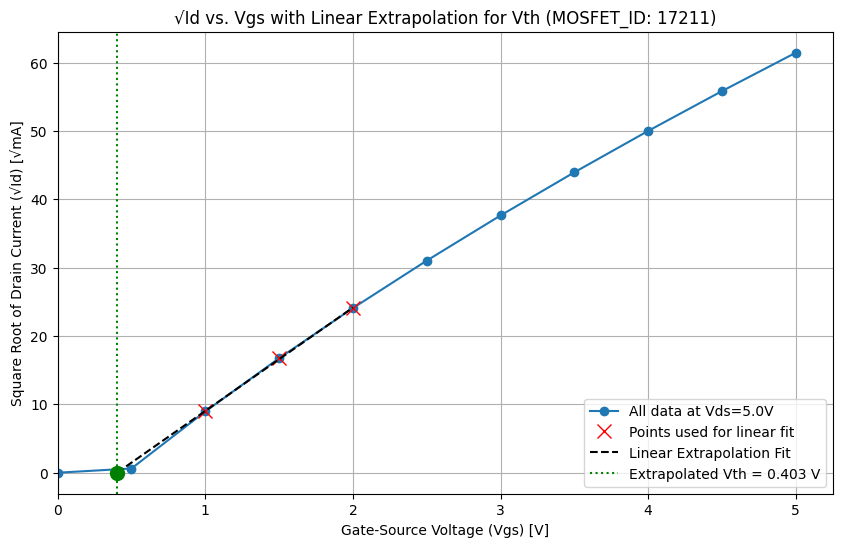

In [28]:
# --- Visualize Extrapolation ---
if not df_sat.empty and extrapolation_data is not None:
    plt.figure(figsize=(10, 6))

    # Plot all sqrt(Id) points for context
    plt.plot(df_sat['VGS'], df_sat['SQRT_ID'] * 1000, marker='o', linestyle='-', label=f'All data at Vds={VDS_SATURATION}V')

    # Highlight points used for linear fit
    plt.plot(extrapolation_data['vgs_linear'], extrapolation_data['sqrt_id_linear'] * 1000,
             marker='x', markersize=10, linestyle='none', color='red', label='Points used for linear fit')

    # Plot the fitted line
    # Generate points for the line spanning the fitted region and extending to Vth
    vgs_fit_line = np.linspace(extrapolation_data['vth'], extrapolation_data['vgs_linear'].max(), 10)
    sqrt_id_fit_line = extrapolation_data['slope'] * vgs_fit_line + extrapolation_data['intercept']
    plt.plot(vgs_fit_line, sqrt_id_fit_line * 1000, linestyle='--', color='black', label='Linear Extrapolation Fit')

    # Mark the extrapolated Vth
    plt.axvline(extrapolation_data['vth'], color='green', linestyle=':', label=f'Extrapolated Vth = {extrapolation_data["vth"]:.3f} V')
    plt.scatter([extrapolation_data['vth']], [0], color='green', s=100, zorder=5) # Mark point on axis

    plt.title(f'√Id vs. Vgs with Linear Extrapolation for Vth (MOSFET_ID: {selected_mosfet_id})')
    plt.xlabel('Gate-Source Voltage (Vgs) [V]')
    plt.ylabel('Square Root of Drain Current (√Id) [√mA]')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=-0.05 * max(df_sat['SQRT_ID'] * 1000)) # Adjust y-lim to show intercept clearly
    plt.xlim(left=0) # Start x-axis at 0 or slightly before min Vgs
    plt.show()

elif df_sat.empty:
    print("Cannot visualize extrapolation due to missing saturation data.")
else: # extrapolation_data is None
     print("Cannot visualize extrapolation because linear fit failed.")